In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import pandas as pd
import random
from keras.models import load_model

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 20 12:07:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Keras guide:

https://keras.io/guides/transfer_learning/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Mestrado final/KFolds mix_data aumentado/trein 2-3-4-5/'
valid_dir = '/content/drive/My Drive/Colab Notebooks/Mestrado final/KFolds mix_data aumentado/1/'
test_dir = '/content/drive/My Drive/Colab Notebooks/Mestrado final/RXT teste mix_data/'

In [ ]:
tf.io.gfile.listdir(data_dir)

['covid', 'dip', 'tuberculose', 'normais']

In [ ]:
image_shape = (224,224,3)
batch_size = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator()

In [ ]:
image_gen.flow_from_directory(data_dir)

Found 4470 images belonging to 4 classes.


# **Creating the model**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense

In [ ]:
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.inception_v3.preprocess_input(x)

inception_v3 = tf.keras.applications.InceptionV3(input_tensor=x, input_shape = image_shape, include_top = False, weights="imagenet", pooling="avg")

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze all the layers
for layer in inception_v3.layers:
    layer.trainable = False

In [ ]:
z = inception_v3.output
predictions = Dense(4, activation='softmax')(z)
model = Model(inputs=inception_v3.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, None, None, 3)        0         ['tf.cast[0][0]']             
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, None, None, 3)        0         ['tf.math.truediv[0][0]'] 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=2)

In [ ]:
model_checkpoint  = ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/Arquiteturas mix aumentado/model_checkpoint1',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True,
    options=None,
    initial_value_threshold=None,
    verbose = 0
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
train_image_gen = image_gen.flow_from_directory(data_dir,
                                                #target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 4470 images belonging to 4 classes.


In [ ]:
validation_image_gen = image_gen.flow_from_directory(valid_dir,
                                                #target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 337 images belonging to 4 classes.


In [ ]:
from sklearn.utils import shuffle
test_image_gen = image_gen.flow_from_directory(test_dir,
                                                     #target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=False
                                               )

Found 298 images belonging to 4 classes.


In [ ]:
train_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

# **Training the model**

In [ ]:
model.fit(train_image_gen,epochs=200,validation_data=validation_image_gen,callbacks=[early_stop,model_checkpoint,reduce_lr])

Epoch 1/200
140/140 [==============================] - 849s 6s/step - loss: 1.0361 - accuracy: 0.5658 - val_loss: 0.7921 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 2/200
140/140 [==============================] - 22s 153ms/step - loss: 0.8257 - accuracy: 0.6826 - val_loss: 0.7559 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 3/200
140/140 [==============================] - 23s 162ms/step - loss: 0.7548 - accuracy: 0.7110 - val_loss: 0.7128 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 4/200
140/140 [==============================] - 22s 157ms/step - loss: 0.7096 - accuracy: 0.7315 - val_loss: 0.6889 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 5/200
140/140 [==============================] - 24s 169ms/step - loss: 0.6709 - accuracy: 0.7483 - val_loss: 0.7241 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 6/200
140/140 [==============================] - 21s 150ms/step - loss: 0.6490 - accuracy: 0.7546 - val_loss: 0.6972 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 7/200
140/140 [===========================

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

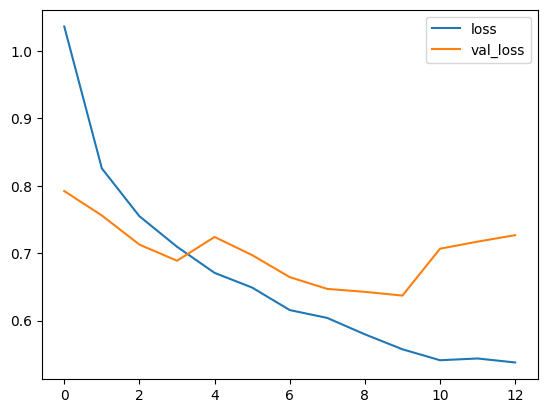

In [ ]:
losses[['loss','val_loss']].plot()

# **Fine tunning**

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/Arquiteturas mix aumentado/model_checkpoint1')

In [ ]:
# Unfreeze all the layers
for layer in model.layers:
    layer.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
train_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

In [ ]:
model.fit(train_image_gen,epochs=10,validation_data=validation_image_gen,callbacks=[model_checkpoint])

Epoch 1/10
140/140 [==============================] - 87s 351ms/step - loss: 1.0466 - accuracy: 0.5781 - val_loss: 1.2975 - val_accuracy: 0.5697
Epoch 2/10
140/140 [==============================] - 46s 325ms/step - loss: 0.5926 - accuracy: 0.7832 - val_loss: 1.3982 - val_accuracy: 0.5252
Epoch 3/10
140/140 [==============================] - 46s 326ms/step - loss: 0.4047 - accuracy: 0.8642 - val_loss: 1.0966 - val_accuracy: 0.6142
Epoch 4/10
140/140 [==============================] - 45s 318ms/step - loss: 0.2588 - accuracy: 0.9289 - val_loss: 0.7543 - val_accuracy: 0.7329
Epoch 5/10
140/140 [==============================] - 47s 334ms/step - loss: 0.1835 - accuracy: 0.9597 - val_loss: 0.5599 - val_accuracy: 0.8249
Epoch 6/10
140/140 [==============================] - 47s 333ms/step - loss: 0.1211 - accuracy: 0.9756 - val_loss: 0.5140 - val_accuracy: 0.8279
Epoch 7/10
140/140 [==============================] - 48s 342ms/step - loss: 0.0900 - accuracy: 0.9839 - val_loss: 0.5164 - val_ac

In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

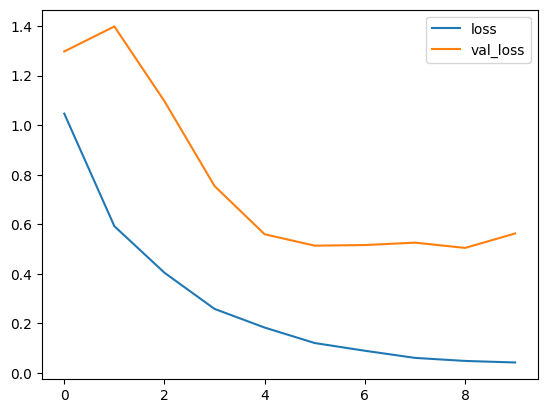

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/Arquiteturas mix aumentado/model_checkpoint1')

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Mestrado final/Novos treinamentos/Arquiteturas mix aumentado/InceptionV3_fine-tuning_RandAugm_avg_4_classes_mix_data_part2345.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(test_image_gen)

10/10 [==============================] - 73s 8s/step - loss: 0.4812 - accuracy: 0.8490


[0.48115524649620056, 0.8489933013916016]

In [ ]:
pred_probabilities = model.predict(test_image_gen)

10/10 [==============================] - 2s 125ms/step


In [ ]:
def int_predict (pred_probabilities):
  predictions = np.zeros((pred_probabilities.shape[0],1),dtype=int)
  i = 0
  while i < pred_probabilities.shape[0]:
    predictions[i,:] = [np.argmax(pred_probabilities[i])]
    i = i + 1

  return predictions

In [ ]:
predictions = int_predict(pred_probabilities)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_image_gen.class_indices

{'covid': 0, 'dip': 1, 'normais': 2, 'tuberculose': 3}

In [ ]:
confusion_matrix(test_image_gen.classes,predictions)

array([[74,  3,  7,  0],
       [ 7, 33,  3,  3],
       [ 4,  1, 72,  7],
       [ 3,  5,  2, 74]])

In [ ]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        84
           1       0.79      0.72      0.75        46
           2       0.86      0.86      0.86        84
           3       0.88      0.88      0.88        84

    accuracy                           0.85       298
   macro avg       0.84      0.83      0.84       298
weighted avg       0.85      0.85      0.85       298



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
y_score = pred_probabilities
num_classes = test_image_gen.num_classes

In [ ]:
# Obtenha as etiquetas verdadeiras de todas as imagens no gerador
y_test = test_image_gen.classes
y_test = label_binarize(y_test, classes=range(num_classes))

In [ ]:
# Calcule as métricas ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

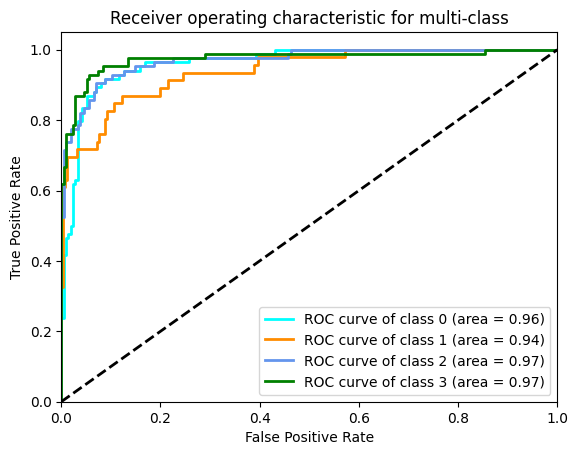

In [ ]:
# Plote a curva ROC para cada classe
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

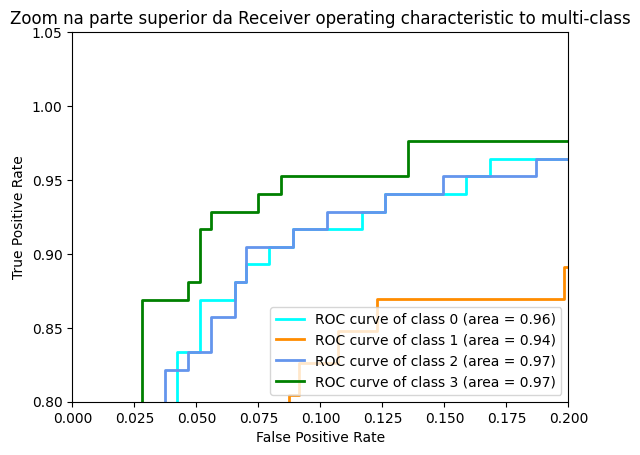

In [ ]:
# Agora, vamos dar zoom em na parte superior esquerda do gráfico.
plt.figure()
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 0.2])  # Ajusta o limite do eixo X para focar no início do gráfico
plt.ylim([0.8, 1.05])  # Ajusta o limite do eixo Y para focar na parte superior do gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoom na parte superior da Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()